# Tarea II: Redes Neuronales Profundas (DNN)

**Fecha:** 28 de septiembre de 2025  

## Resumen

El objetivo de esta tarea es practicar la formulación e implementación de
problemas de regresión y clasificación usando PyTorch. Entregue un único archivo
comprimido que contenga el cuaderno `.ipynb` y un PDF exportado del mismo.

Siga las indicaciones en cada problema. Este cuaderno contiene la estructura
y celdas plantilla (dos celdas de código por ejercicio). NO resuelva los
ejercicios en las celdas de ejemplo que no correspondan a su implementación final;
documente supuestos y decisiones en celdas Markdown.


In [64]:
# Imports y configuración global (plantilla)
import os
import math
import random
import kaggle
import numpy as np
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = get_device(); set_seed(42)

## Utilidades comunes

Plantillas de funciones de entrenamiento, evaluación y visualización que puede
adaptar para cada problema. Mantenga estas funciones generales en caso de reuse.

In [63]:
# función para entrenar el modelo (mejor manejo de gradientes y evaluación por época)
def train_model(model, optimizer, criterion, train_DL, X_val, y_val, num_epochs, device=None):
    """
    Entrena el modelo y devuelve dos listas: pérdidas de entrenamiento y de validación
    por época. Esta versión: 1) pone optimizer.zero_grad() antes del forward/backward,
    2) computa la pérdida de validación fuera del bucle de batches (una vez por época),
    3) asegura el uso opcional del device y devuelve pérdidas medias por época.
    """
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_DL:
            # Preparar tensores en device y forma correcta
            y_batch = y_batch.squeeze()
            if device is not None:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            # Asegurar que shapes coincidan (squeeze si es necesario)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        # Pérdida media de entrenamiento en la época
        train_epoch_loss = float(np.mean(batch_losses)) if len(batch_losses) > 0 else 0.0
        train_losses.append(train_epoch_loss)

        # Evaluación sobre el conjunto de validación (una vez por época)
        model.eval()
        with torch.no_grad():
            if device is not None:
                X_val_d = X_val.to(device)
                y_val_d = y_val.to(device)
            else:
                X_val_d = X_val
                y_val_d = y_val
            outputs_val = model(X_val_d)
            val_loss = float(criterion(outputs_val.squeeze(), y_val_d).item())
            val_losses.append(val_loss)

        if (epoch+1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_epoch_loss:.6f} Val Loss: {val_loss:.6f}")

    return train_losses, val_losses

def plot_loss_vs_iter(train_losses, val_losses=None, title='Loss vs Iteraciones'):
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train')
    if val_losses is not None:
        plt.plot(val_losses, label='Val')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def polars_info(df):
    """
    Imprime información similar a df.info() de pandas, pero para un DataFrame de Polars.
    Si hay muchas columnas, muestra solo las primeras 5 en los prints tabulares.
    """
    print("Schema / tipos de columna:")
    print(df.schema)
    print("\nConteo de nulos por columna:")
    nulls = df.null_count()
    n_cols = nulls.shape[1]
    step = 5
    for i in range(0, n_cols, step):
        print(nulls[:, i:i+step])
        if i + step < n_cols:
            print(f"... ({n_cols} columnas en total, mostrando columnas {i+1}-{min(i+step, n_cols)})")

    print("\nTamaño estimado en memoria:")
    try:
        size_bytes = df.estimated_size()
        size_kb = size_bytes / 1024
        size_mb = size_kb / 1024
        print(f"{size_bytes:.2f} bytes")
        print(f"{size_kb:.2f} KB")
        print(f"{size_mb:.4f} MB")
    except Exception:
        pass

    print("\nEstadísticas descriptivas:")
    try:
        desc = df.describe()
        n_cols = desc.shape[1]
        step = 5
        for i in range(0, n_cols, step):
            print(desc[:, i:i+step])
            if i + step < n_cols:
                print(f"... ({n_cols} columnas en total, mostrando columnas {i+1}-{min(i+step, n_cols)})")
    except Exception:
        pass



---

## Problema 1 — Regresión: consumo de combustible (Dataset [1])

Considere el dataset de [1]. Realice un script en PyTorch para resolver el problema de regresión asociado a la predicción del consumo de combustible en ciudad (city) y en carretera (highway). Puede emplear dos modelos lineales separados, uno para cada variable objetivo.

Se requiere documentar todos los supuestos y operaciones de preprocesamiento: elección de características, imputación de valores faltantes, codificación de variables categóricas, normalización o escalado, división en conjuntos de entrenamiento/validación/prueba y las métricas empleadas (MSE, MAE). Indique y justifique los hiperparámetros de optimización seleccionados. Muestre un gráfico de error vs iteraciones y un gráfico de predicción vs valores reales.

Enlace: https://www.kaggle.com/datasets/rinichristy/2022-fuel-consumption-ratings


In [732]:
import polars as pl
import os
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("rinichristy/2022-fuel-consumption-ratings")
csv_file = os.path.join(path, "MY2022 Fuel Consumption Ratings.csv")

df = pl.read_csv(csv_file)
df.head()


Model Year,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating
i64,str,str,str,f64,i64,str,str,f64,f64,f64,i64,i64,i64,i64
2022,"""Acura""","""ILX""","""Compact""",2.4,4,"""AM8""","""Z""",9.9,7.0,8.6,33,200,6,3
2022,"""Acura""","""MDX SH-AWD""","""SUV: Small""",3.5,6,"""AS10""","""Z""",12.6,9.4,11.2,25,263,4,5
2022,"""Acura""","""RDX SH-AWD""","""SUV: Small""",2.0,4,"""AS10""","""Z""",11.0,8.6,9.9,29,232,5,6
2022,"""Acura""","""RDX SH-AWD A-SPEC""","""SUV: Small""",2.0,4,"""AS10""","""Z""",11.3,9.1,10.3,27,242,5,6
2022,"""Acura""","""TLX SH-AWD""","""Compact""",2.0,4,"""AS10""","""Z""",11.2,8.0,9.8,29,230,5,7


In [733]:
df.sample(10)

Model Year,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),Fuel Consumption(Comb (L/100 km)),Fuel Consumption(Comb (mpg)),CO2 Emissions(g/km),CO2 Rating,Smog Rating
i64,str,str,str,f64,i64,str,str,f64,f64,f64,i64,i64,i64,i64
2022,"""Chevrolet""","""Silverado 4WD""","""Pickup truck: Standard""",2.7,4,"""A8""","""X""",13.9,12.0,13.1,22,306,3,6
2022,"""BMW""","""M8 Cabriolet""","""Subcompact""",4.4,8,"""AS8""","""Z""",16.1,11.0,13.8,20,322,3,3
2022,"""Volkswagen""","""Golf R""","""Mid-size""",2.0,4,"""AM7""","""Z""",10.3,7.7,9.1,31,213,5,5
2022,"""Porsche""","""718 Boxster GTS 4.0""","""Two-seater""",4.0,6,"""AM7""","""Z""",12.3,9.8,11.1,25,260,4,5
2022,"""Kia""","""Seltos AWD""","""SUV: Small""",2.0,4,"""AV8""","""X""",8.8,7.6,8.2,34,195,6,5
2022,"""Lexus""","""ES 350""","""Mid-size""",3.5,6,"""AS8""","""X""",10.7,7.3,9.2,31,214,5,5
2022,"""Audi""","""TTS Coupe quattro""","""Subcompact""",2.0,4,"""AM7""","""Z""",10.0,7.7,9.0,31,209,5,3
2022,"""BMW""","""X6 M50i""","""SUV: Standard""",4.4,8,"""AS8""","""Z""",14.4,10.6,12.7,22,302,3,3
2022,"""Dodge""","""Charger Widebody (MDS)""","""Full-size""",6.4,8,"""A8""","""Z""",15.8,9.6,13.0,22,305,3,1


### Análisis Exploratorio de los Datos

Al revisar el conjunto de datos, se observa que **no existen valores nulos** en ninguna columna 

Las **columnas numéricas** (`Int64`, `Float64`) incluyen variables como:
- Año del vehículo
- Tamaño del motor
- Número de cilindros
- Consumo de combustible (en ciudad, carretera, combinado)
- Emisiones de CO₂

Las **columnas categóricas** (`String`) corresponden a:
- Marca
- Modelo
- Clase de vehículo
- Transmisión
- Tipo de combustible

Estas variables representan información cualitativa. Para utilizarlas en modelos lineales (como regresión logística o lineal), es necesario transformarlas mediante **One Hot Encoding**. 


**Model Year** por otra parte es constante y no aporta información relevante al modelo, por lo que se decide eliminarla del dataset.

Además, Fuel Consumption(Comb (L/100 km)) y Fuel Consumption(Comb (mpg)) son variables derivadas de los objetivos de consumo de combustible en ciudad y carretera, por lo que también se eliminan del dataset.


In [554]:
import polars as pl

categorical_cols = ['Make', 'Vehicle Class', 'Transmission', 'Fuel Type']

for col in categorical_cols:
    uniques = df.select(col).unique()
    print(f"Valores únicos para '{col}':")
    print(uniques)
    print('-' * 40)


Valores únicos para 'Make':
shape: (39, 1)
┌────────────┐
│ Make       │
│ ---        │
│ str        │
╞════════════╡
│ BMW        │
│ Genesis    │
│ Alfa Romeo │
│ Volvo      │
│ MINI       │
│ …          │
│ Chrysler   │
│ FIAT       │
│ Nissan     │
│ Porsche    │
│ Audi       │
└────────────┘
----------------------------------------
Valores únicos para 'Vehicle Class':
shape: (14, 1)
┌─────────────────────────┐
│ Vehicle Class           │
│ ---                     │
│ str                     │
╞═════════════════════════╡
│ Subcompact              │
│ SUV: Small              │
│ Two-seater              │
│ Full-size               │
│ Pickup truck: Small     │
│ …                       │
│ Compact                 │
│ Minicompact             │
│ Pickup truck: Standard  │
│ Station wagon: Mid-size │
│ Station wagon: Small    │
└─────────────────────────┘
----------------------------------------
Valores únicos para 'Transmission':
shape: (23, 1)
┌──────────────┐
│ Transmission │
│ ---  

In [555]:
df.select(pl.col("Fuel Consumption (City (L/100 km)"))

Fuel Consumption (City (L/100 km)
f64
9.9
12.6
11.0
11.3
11.2
…
10.7
10.5
11.0


Por lo visto, la columna modelo es extremada mente grande en cuanto a valores unico
como para ser considerada en el onehot, la mejor opción es eliminarla del dataset.

In [556]:
df = df.drop(["Model", "Model Year", "Fuel Consumption(Comb (L/100 km))", "Fuel Consumption(Comb (mpg))"])  # Eliminar la columna 'Model' y 'Model Year' debido a su alta cardinalidad

In [557]:
# Importar onehotencoder
from sklearn.preprocessing import OneHotEncoder

# Hacer one hot encoding a las columnas categóricas
categorical_cols = ['Make', 'Vehicle Class', 'Transmission', 'Fuel Type']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar multicolinealidad
encoded_data = encoder.fit_transform(df.select(categorical_cols).to_numpy())
encoded_df = pl.DataFrame(encoded_data, schema=encoder.get_feature_names_out(categorical_cols).tolist())

In [558]:

numeric_cols = [col for col in df.columns if col not in categorical_cols]
df_numeric = df.select(numeric_cols)
df_merged = pl.concat([df_numeric, encoded_df], how="horizontal")
df_merged.head()

Engine Size(L),Cylinders,Fuel Consumption (City (L/100 km),Fuel Consumption(Hwy (L/100 km)),CO2 Emissions(g/km),CO2 Rating,Smog Rating,Make_Alfa Romeo,Make_Aston Martin,Make_Audi,Make_BMW,Make_Bentley,Make_Bugatti,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ford,Make_GMC,Make_Genesis,Make_Honda,Make_Hyundai,Make_Infiniti,Make_Jaguar,Make_Jeep,Make_Kia,Make_Lamborghini,Make_Land Rover,Make_Lexus,Make_Lincoln,Make_MINI,Make_Maserati,Make_Mazda,Make_Mercedes-Benz,Make_Mitsubishi,…,Vehicle Class_Mid-size,Vehicle Class_Minicompact,Vehicle Class_Minivan,Vehicle Class_Pickup truck: Small,Vehicle Class_Pickup truck: Standard,Vehicle Class_SUV: Small,Vehicle Class_SUV: Standard,Vehicle Class_Special purpose vehicle,Vehicle Class_Station wagon: Mid-size,Vehicle Class_Station wagon: Small,Vehicle Class_Subcompact,Vehicle Class_Two-seater,Transmission_A6,Transmission_A7,Transmission_A8,Transmission_A9,Transmission_AM6,Transmission_AM7,Transmission_AM8,Transmission_AS10,Transmission_AS5,Transmission_AS6,Transmission_AS7,Transmission_AS8,Transmission_AS9,Transmission_AV,Transmission_AV1,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel Type_E,Fuel Type_X,Fuel Type_Z
f64,i64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.4,4,9.9,7.0,200,6,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3.5,6,12.6,9.4,263,4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2.0,4,11.0,8.6,232,5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2.0,4,11.3,9.1,242,5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2.0,4,11.2,8.0,230,5,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Primer modelo para el objetivo de consumo en ciudad (city)


In [559]:
# Split data
from sklearn.model_selection import train_test_split

X = df_merged.drop("Fuel Consumption (City (L/100 km)")
y = df_merged["Fuel Consumption (City (L/100 km)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).to(device)

Usare principalmente 32 de tamaño de batch ya que es un tamaño comúnmente utilizado que equilibra la eficiencia computacional y la estabilidad del entrenamiento. Además, es una potencia de 2, lo que puede aprovechar mejor las optimizaciones de hardware en muchas arquitecturas de GPU.

Además usare un paso de 0.01 que ayudara a que el modelo converja de manera más rápida, ya que el dataset no es muy grande.

Comenzare con 100 epocas, ya que es un número razonable para observar el comportamiento del modelo sin sobreentrenarlo. Si el modelo no converge o muestra signos de sobreajuste, ajustaré este número en consecuencia.

756 20
24
MLR(
  (output_layer): Linear(in_features=82, out_features=1, bias=True)
)


Epoch [1/100] Train Loss: 160.514292 Val Loss: 155.033295
Epoch [5/100] Train Loss: 131.297108 Val Loss: 128.679916
Epoch [10/100] Train Loss: 106.533497 Val Loss: 103.817192
Epoch [15/100] Train Loss: 85.447006 Val Loss: 82.845718
Epoch [20/100] Train Loss: 67.924837 Val Loss: 65.676758
Epoch [25/100] Train Loss: 53.175850 Val Loss: 51.054966
Epoch [30/100] Train Loss: 40.954990 Val Loss: 39.368488
Epoch [35/100] Train Loss: 31.165522 Val Loss: 29.880737
Epoch [40/100] Train Loss: 23.251091 Val Loss: 22.277979
Epoch [45/100] Train Loss: 17.155356 Val Loss: 16.256458
Epoch [50/100] Train Loss: 12.320650 Val Loss: 11.543984
Epoch [55/100] Train Loss: 8.691745 Val Loss: 8.173661
Epoch [60/100] Train Loss: 5.964630 Val Loss: 5.616985
Epoch [65/100] Train Loss: 4.059542 Val Loss: 3.791131
Epoch [70/100] Train Loss: 2.690887 Val Loss: 2.502092
Epoch [75/100] Train Loss: 1.771662 Val Loss: 1.660456
Epoch [80/100] Train Loss: 1.153816 Val Loss: 1.091115
Epoch [85/100] Train Loss: 0.763866 Val

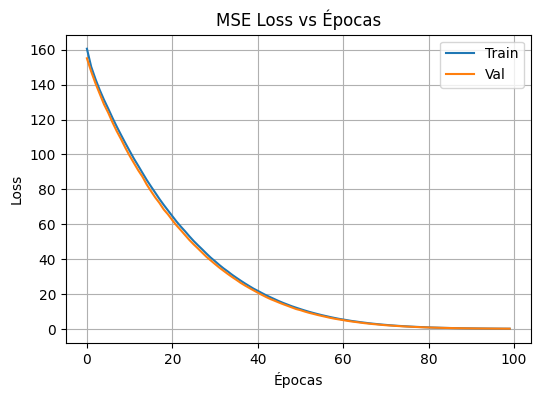

In [560]:
from torch.utils.data import Dataset, DataLoader

# Data Loader
class my_DL(Dataset):
    
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.y)

my_train_data = my_DL(X_train, y_train)

# Batches
batch_size = 32
print(len(X_train), X_train.shape[0] % batch_size)
train_DL = DataLoader(dataset=my_train_data, batch_size=batch_size, shuffle=True, drop_last=False)
print(len(train_DL))

# Multiclass Logistic Regression Model
class MLR(nn.Module):
    def __init__(self, n_input, n_classes):
        super(MLR, self).__init__()
        self.output_layer = nn.Linear(n_input, n_classes)
    
    def forward(self, x):
        return self.output_layer(x)
    
n_input = X_train.shape[1]
n_classes = 1  # Regresión
model = MLR(n_input, n_classes).to(device)
print(model)

# Optimizer and Loss
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100
criterion = nn.MSELoss()

# Asegurar que X_test/y_test estén en device y tengan dimensiones compatibles
X_val = X_test.to(device) if hasattr(X_test, 'to') else X_test
y_val = y_test.to(device) if hasattr(y_test, 'to') else y_test

train_losses, val_losses = train_model(model, optimizer, criterion, train_DL, X_val, y_val, num_epochs, device=device)
plot_loss_vs_iter(train_losses, val_losses, title='MSE Loss vs Épocas')

In [561]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# To compute accuracy
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)
    
# To compute accuracy

# Convert predictions and labels to CPU and numpy
y_train_np = y_train.cpu().numpy()
y_test_np = y_test.cpu().numpy()
pred_train_np = predictions_train.cpu().detach().numpy().flatten()
pred_test_np = predictions_test.cpu().detach().numpy().flatten()

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_np, pred_train_np))
rmse_test = np.sqrt(mean_squared_error(y_test_np, pred_test_np))

# MAPE
mape_train = mean_absolute_percentage_error(y_train_np, pred_train_np)
mape_test = mean_absolute_percentage_error(y_test_np, pred_test_np)

# R2 Score
r2_train = r2_score(y_train_np, pred_train_np)
r2_test = r2_score(y_test_np, pred_test_np)

print(f"Train RMSE: {rmse_train:.3f} | Test RMSE: {rmse_test:.3f}")
print(f"Train MAPE: {mape_train*100:.2f}% | Test MAPE: {mape_test*100:.2f}%")
print(f"Train R2: {r2_train:.3f} | Test R2: {r2_test:.3f}")


Train RMSE: 0.528 | Test RMSE: 0.555
Train MAPE: 3.45% | Test MAPE: 3.57%
Train R2: 0.976 | Test R2: 0.975


### Segundo modelo para el objetivo de consumo en carretera (highway)


756 20
24
MLR(
  (output_layer): Linear(in_features=82, out_features=1, bias=True)
)
Epoch [1/100] Train Loss: 91.701455 Val Loss: 90.193367
Epoch [5/100] Train Loss: 71.246102 Val Loss: 71.017281
Epoch [10/100] Train Loss: 53.558038 Val Loss: 53.083740
Epoch [15/100] Train Loss: 39.711795 Val Loss: 39.171516
Epoch [20/100] Train Loss: 28.759398 Val Loss: 28.282001
Epoch [25/100] Train Loss: 20.323498 Val Loss: 19.969097
Epoch [30/100] Train Loss: 14.007893 Val Loss: 13.798163
Epoch [35/100] Train Loss: 9.390013 Val Loss: 9.184343
Epoch [40/100] Train Loss: 6.115315 Val Loss: 6.028026
Epoch [45/100] Train Loss: 3.849486 Val Loss: 3.854778
Epoch [50/100] Train Loss: 2.384671 Val Loss: 2.409918
Epoch [55/100] Train Loss: 1.472844 Val Loss: 1.512305
Epoch [60/100] Train Loss: 0.897365 Val Loss: 0.958136
Epoch [65/100] Train Loss: 0.552533 Val Loss: 0.625566
Epoch [70/100] Train Loss: 0.376891 Val Loss: 0.447832
Epoch [75/100] Train Loss: 0.282970 Val Loss: 0.347562
Epoch [80/100] Train Lo

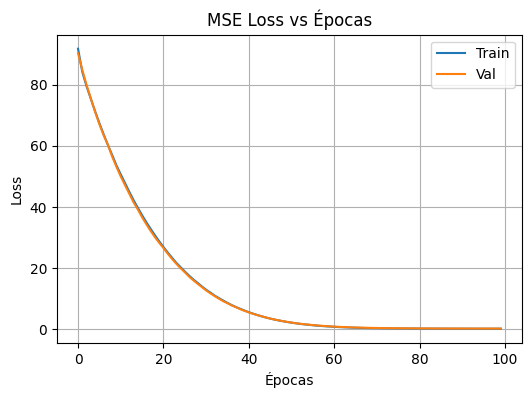

In [563]:
# Split data
from sklearn.model_selection import train_test_split

X = df_merged.drop("Fuel Consumption(Hwy (L/100 km))")
y = df_merged["Fuel Consumption(Hwy (L/100 km))"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).to(device)

from torch.utils.data import Dataset, DataLoader

# Data Loader
class my_DL(Dataset):
    
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.y)

my_train_data = my_DL(X_train, y_train)

# Batches
batch_size = 32
print(len(X_train), X_train.shape[0] % batch_size)
train_DL = DataLoader(dataset=my_train_data, batch_size=batch_size, shuffle=True, drop_last=False)
print(len(train_DL))

# Multiclass Logistic Regression Model
class MLR(nn.Module):
    def __init__(self, n_input, n_classes):
        super(MLR, self).__init__()
        self.output_layer = nn.Linear(n_input, n_classes)
    
    def forward(self, x):
        return self.output_layer(x)
    
n_input = X_train.shape[1]
n_classes = 1  # Regresión
model = MLR(n_input, n_classes).to(device)
print(model)

# Optimizer and Loss
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100
criterion = nn.MSELoss()

# Asegurar que X_test/y_test estén en device y tengan dimensiones compatibles
X_val = X_test.to(device) if hasattr(X_test, 'to') else X_test
y_val = y_test.to(device) if hasattr(y_test, 'to') else y_test

train_losses, val_losses = train_model(model, optimizer, criterion, train_DL, X_val, y_val, num_epochs, device=device)
plot_loss_vs_iter(train_losses, val_losses, title='MSE Loss vs Épocas')

In [564]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# To compute accuracy
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)
    
# To compute accuracy

# Convert predictions and labels to CPU and numpy
y_train_np = y_train.cpu().numpy()
y_test_np = y_test.cpu().numpy()
pred_train_np = predictions_train.cpu().detach().numpy().flatten()
pred_test_np = predictions_test.cpu().detach().numpy().flatten()

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train_np, pred_train_np))
rmse_test = np.sqrt(mean_squared_error(y_test_np, pred_test_np))

# MAPE
mape_train = mean_absolute_percentage_error(y_train_np, pred_train_np)
mape_test = mean_absolute_percentage_error(y_test_np, pred_test_np)

# R2 Score
r2_train = r2_score(y_train_np, pred_train_np)
r2_test = r2_score(y_test_np, pred_test_np)

print(f"Train RMSE: {rmse_train:.3f} | Test RMSE: {rmse_test:.3f}")
print(f"Train MAPE: {mape_train*100:.2f}% | Test MAPE: {mape_test*100:.2f}%")
print(f"Train R2: {r2_train:.3f} | Test R2: {r2_test:.3f}")


Train RMSE: 0.425 | Test RMSE: 0.487
Train MAPE: 3.26% | Test MAPE: 3.61%
Train R2: 0.965 | Test R2: 0.955




## Problema 2 — Aproximación polinómica de $f(x)=2^{\cos(x^2)},\; x\in I=[-\pi,\pi]$

Aproximar $f(x)=2^{\cos(x^2)}$ mediante un polinomio de orden $n$:\
$$
h(x;\theta,n)=\sum_{j=0}^n \theta_j x^j,\quad \theta=(\theta_0,\dots,\theta_n)^T
$$

El dataset $D$ es un muestreo de $f$ en $I$ con $m$ puntos. Elegir $n$ justificando
el trade-off bias/varianza. Definir el modelo en PyTorch y optimizar los parámetros
con MSE como métrica. Mostrar gráfico de error vs iteraciones y la aproximación
$h(x)$ frente a $f(x)$.


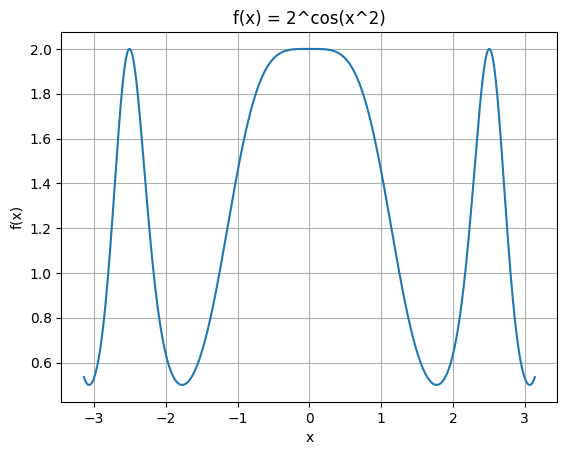

In [576]:
def func(x):
    return 2 ** torch.cos(x ** 2)
# Grafica la funcion
x = torch.linspace(-math.pi, math.pi, 600)
y = func(x)
plt.plot(x.numpy(), y.numpy())
plt.title('f(x) = 2^cos(x^2)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()


Epoch 1/800000 Loss: 300646624.000000
Epoch 200/800000 Loss: 297608704.000000
Epoch 400/800000 Loss: 294576480.000000
Epoch 600/800000 Loss: 291566336.000000
Epoch 800/800000 Loss: 288579136.000000
Epoch 1000/800000 Loss: 285611712.000000
Epoch 1200/800000 Loss: 282666368.000000
Epoch 1400/800000 Loss: 279740704.000000
Epoch 1600/800000 Loss: 276833056.000000
Epoch 1800/800000 Loss: 273948416.000000
Epoch 2000/800000 Loss: 271079616.000000
Epoch 2200/800000 Loss: 268227552.000000
Epoch 2400/800000 Loss: 265399104.000000
Epoch 2600/800000 Loss: 262586480.000000
Epoch 2800/800000 Loss: 259789072.000000
Epoch 3000/800000 Loss: 257007520.000000
Epoch 3200/800000 Loss: 254246272.000000
Epoch 3400/800000 Loss: 251503920.000000
Epoch 3600/800000 Loss: 248776928.000000
Epoch 3800/800000 Loss: 246065200.000000
Epoch 4000/800000 Loss: 243368464.000000
Epoch 4200/800000 Loss: 240686768.000000
Epoch 4400/800000 Loss: 238020640.000000
Epoch 4600/800000 Loss: 235369184.000000
Epoch 4800/800000 Loss:

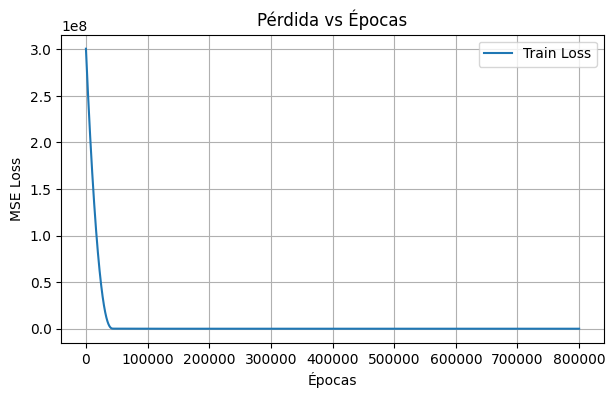

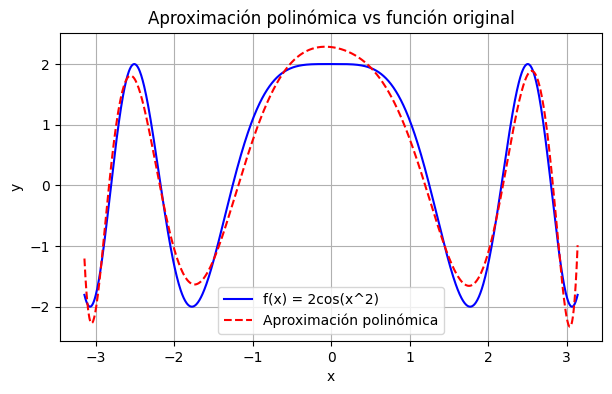

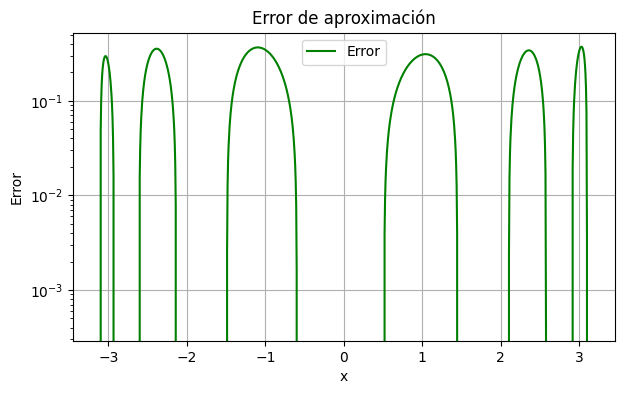

In [754]:
# Datos
x = torch.linspace(-math.pi, math.pi, 1000).to(device)
y = 2 * torch.cos(x ** 2)

grado = 12
X_poly = torch.vstack([x**i for i in range(grado+1)]).T  

# Modelo lineal
model = nn.Linear(grado+1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.000002)
criterion = nn.MSELoss()

# Entrenamiento
num_epochs = 800000
train_losses = [] 
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_poly)
    loss = criterion(outputs.squeeze(), y)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())  # Guardar la pérdida
    if (epoch+1) % 200 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.6f}")


plt.figure(figsize=(7,4))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Épocas')
plt.ylabel('MSE Loss')
plt.title('Pérdida vs Épocas')
plt.legend()
plt.grid(True)
plt.show()

# Predicción y gráfica
with torch.no_grad():
    y_pred = model(X_poly).squeeze().cpu().numpy()

plt.figure(figsize=(7,4))
plt.plot(x.cpu().numpy(), y.cpu().numpy(), label='f(x) = 2cos(x^2)', color='blue')
plt.plot(x.cpu().numpy(), y_pred, label='Aproximación polinómica', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Aproximación polinómica vs función original')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico del error logarítmico
error = y.cpu().numpy() - y_pred
plt.figure(figsize=(7,4))
plt.plot(x.cpu().numpy(), error, label='Error', color='green')
plt.xlabel('x')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Error de aproximación')
plt.legend()
plt.grid(True)
plt.show()

In [755]:
print(list(model.parameters()))

[Parameter containing:
tensor([[ 1.3105e+00, -1.4668e-01, -9.7835e-01,  3.0481e-01, -8.0408e-01,
         -1.7724e-01,  2.5342e-01,  4.2097e-02,  8.1024e-03, -4.3751e-03,
         -6.2883e-03,  1.6530e-04,  3.8190e-04]], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([0.9700], device='cuda:0', requires_grad=True)]


Elegí principalmente 12 como grado del polinomio ya que permite capturar la complejidad de la función sin sobreajustar los datos. Además, una limitante es el poder computacional, ya que se podría obtener un mejor ajuste con grados más altos, pero el tiempo de entrenamiento y los recursos necesarios aumentarían significativamente.

El tiempo de entreno de 3 minutos es razonable para observar el comportamiento del modelo sin sobreentrenarlo. Al igual que el learning_rate, para que el modelo converja por debajo de un error de 1, utilice una gran cantidad de epochs y un 
lr de 0.00001


## Problema 3 — Clasificación binaria (horsesurvival) (Dataset [2])

Considere el dataset de [2]. Realice un script en PyTorch para resolver el problema de **clasificación binaria** asociado a predecir si un caballo sobrevivirá o no. Documente todos los **supuestos** y operaciones de **preprocesamiento**: selección de características, imputación de valores faltantes, codificación de variables categóricas, normalización o escalado, división en conjuntos de entrenamiento/validación/prueba y las métricas empleadas (accuracy, F1, etc.). Indique y justifique los **hiperparámetros de optimización** seleccionados (tasa de aprendizaje, batch size, número de épocas, etc.). 

Incluya un gráfico de **error vs iteraciones** y un gráfico de las **predicciones vs etiquetas reales** para analizar el desempeño del modelo. 

Explique cada decisión tomada en el pipeline, justificando con base en el problema y las características del dataset.

Enlace: https://www.kaggle.com/datasets/yasserh/horsesurvivalprognostication



In [724]:
import polars as pl
import os
import kagglehub


path = kagglehub.dataset_download("yasserh/horsesurvivalprognostication")

csv_files = [f for f in os.listdir(path) if f.lower().endswith('.csv')]
if len(csv_files) == 0:
    raise FileNotFoundError("No se encontró ningún archivo CSV en el directorio descargado.")
csv_file = os.path.join(path, csv_files[0])

# Leer el archivo CSV con manejo de nulos y errores comunes
df = pl.read_csv(
    csv_file,
    ignore_errors=True,
    null_values=["", "NA", "NaN", "NULL", "None", "none"],
    infer_schema_length=200
)

In [725]:
df.head()

surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
str,str,i64,f64,i64,i64,str,str,str,str,str,str,str,str,str,f64,str,str,i64,f64,str,f64,str,str,i64,i64,i64,str
"""no""","""adult""",530101,38.5,66,28,"""cool""","""reduced""",null,"""more_3_sec""","""extreme_pain""","""absent""","""severe""",null,null,null,"""decreased""","""distend_large""",45,8.4,null,null,"""died""","""no""",11300,0,0,"""no"""
"""yes""","""adult""",534817,39.2,88,20,null,null,"""pale_cyanotic""","""less_3_sec""","""mild_pain""","""absent""","""slight""",null,null,null,"""absent""","""other""",50,85.0,"""cloudy""",2.0,"""euthanized""","""no""",2208,0,0,"""no"""
"""no""","""adult""",530334,38.3,40,24,"""normal""","""normal""","""pale_pink""","""less_3_sec""","""mild_pain""","""hypomotile""",null,null,null,null,"""normal""","""normal""",33,6.7,null,null,"""lived""","""no""",0,0,0,"""yes"""
"""yes""","""young""",5290409,39.1,164,84,"""cold""","""normal""","""dark_cyanotic""","""more_3_sec""","""depressed""","""absent""","""severe""",null,"""less_1_liter""",5.0,"""decreased""",null,48,7.2,"""serosanguious""",5.3,"""died""","""yes""",2208,0,0,"""yes"""
"""no""","""adult""",530255,37.3,104,35,null,null,"""dark_cyanotic""","""more_3_sec""",null,null,null,null,null,null,null,null,74,7.4,null,null,"""died""","""no""",4300,0,0,"""no"""


In [726]:
polars_info(df)

Schema / tipos de columna:
Schema({'surgery': String, 'age': String, 'hospital_number': Int64, 'rectal_temp': Float64, 'pulse': Int64, 'respiratory_rate': Int64, 'temp_of_extremities': String, 'peripheral_pulse': String, 'mucous_membrane': String, 'capillary_refill_time': String, 'pain': String, 'peristalsis': String, 'abdominal_distention': String, 'nasogastric_tube': String, 'nasogastric_reflux': String, 'nasogastric_reflux_ph': Float64, 'rectal_exam_feces': String, 'abdomen': String, 'packed_cell_volume': Int64, 'total_protein': Float64, 'abdomo_appearance': String, 'abdomo_protein': Float64, 'outcome': String, 'surgical_lesion': String, 'lesion_1': Int64, 'lesion_2': Int64, 'lesion_3': Int64, 'cp_data': String})

Conteo de nulos por columna:
shape: (1, 5)
┌─────────┬─────┬─────────────────┬─────────────┬───────┐
│ surgery ┆ age ┆ hospital_number ┆ rectal_temp ┆ pulse │
│ ---     ┆ --- ┆ ---             ┆ ---         ┆ ---   │
│ u32     ┆ u32 ┆ u32             ┆ u32         ┆ u32   

In [727]:
# Filtra columnas con valores nulos
cols_nulls = [col for col in df.columns if col != "Outcome" and df.select(pl.col(col)).null_count().item() != 0]
df_nulls = df.select(cols_nulls)
df_nulls.sample(10)

rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein
f64,i64,i64,str,str,str,str,str,str,str,str,str,f64,str,str,i64,f64,str,f64
38.5,100,null,"""cool""","""reduced""","""bright_red""","""more_3_sec""","""severe_pain""","""hypomotile""","""severe""","""slight""",null,null,"""absent""","""distend_large""",null,null,null,null
39.3,64,90,"""warm""","""reduced""","""normal_pink""","""less_3_sec""",null,"""hypomotile""",null,null,"""less_1_liter""",6.5,"""normal""","""distend_large""",39,6.7,null,null
38.0,44,12,"""warm""","""normal""","""pale_pink""","""less_3_sec""","""mild_pain""","""absent""","""moderate""",null,"""less_1_liter""",6.5,"""normal""","""distend_small""",33,6.5,null,null
38.0,140,68,"""normal""","""normal""","""normal_pink""","""less_3_sec""","""mild_pain""","""hypomotile""","""slight""",null,null,null,"""increased""","""normal""",39,5.3,null,null
38.1,40,36,"""normal""","""increased""","""bright_pink""","""less_3_sec""","""depressed""","""normal""",null,null,null,null,null,null,null,null,null,null
37.5,48,16,"""normal""","""normal""","""normal_pink""","""less_3_sec""","""alert""","""hypermotile""",null,null,null,null,"""normal""",null,37,6.5,null,null
38.2,48,null,"""warm""",null,"""normal_pink""","""more_3_sec""","""mild_pain""","""hypomotile""",null,"""slight""",null,null,null,"""other""",34,6.6,null,null
37.8,60,80,"""normal""","""reduced""","""bright_pink""","""more_3_sec""","""depressed""","""hypomotile""","""moderate""",null,"""less_1_liter""",5.5,"""absent""",null,40,4.5,"""cloudy""",null
38.6,88,28,null,null,null,null,null,null,null,null,null,null,null,null,35,5.9,null,null


Manejare los nulos primero analizando las columnas que los contienen, posteriormente separare entre las tipo categoricas y numéricas para tratarlas de manera diferente.

In [728]:
df_nulls_string = df_nulls.select(pl.col(pl.String))
df_nulls_string.describe().slice(1, 1)

statistic,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance
str,str,str,str,str,str,str,str,str,str,str,str,str
"""null_count""","""56""","""69""","""47""","""32""","""55""","""44""","""131""","""175""","""225""","""102""","""118""","""165"""


In [729]:
df_nulls_numeric = df_nulls.select(pl.col(pl.Float64, pl.Int64))
df_nulls_numeric.describe().slice(1, 1)

statistic,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein
str,f64,f64,f64,f64,f64,f64,f64
"""null_count""",60.0,24.0,58.0,246.0,31.0,33.0,198.0


Se tienen alrededor de 299 muestras en en el dataset por lo que veo inviable mantener algunas columnas con muchos nulos, ya que se perdería mucha información. Igualmente algunas categoricas como abd_appearance tiene muchos nulos, otras numericas como nasogastric_reflux_ph y abdomo_protein tienen alrededor de más de 2/3 de nulos, por lo que se decide eliminar estas columnas del dataset.

Igualmente en las categoricas falta analizar la cantidad valores unicos para llegar a una conclsión sobre cuales eliminar.

In [730]:

categorical_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype == pl.String]

for col in categorical_cols:
    uniques = df.select(col).unique()
    print(f"Valores únicos para '{col}':")
    print(uniques)
    print('-' * 40)

Valores únicos para 'surgery':
shape: (2, 1)
┌─────────┐
│ surgery │
│ ---     │
│ str     │
╞═════════╡
│ no      │
│ yes     │
└─────────┘
----------------------------------------
Valores únicos para 'age':
shape: (2, 1)
┌───────┐
│ age   │
│ ---   │
│ str   │
╞═══════╡
│ young │
│ adult │
└───────┘
----------------------------------------
Valores únicos para 'temp_of_extremities':
shape: (5, 1)
┌─────────────────────┐
│ temp_of_extremities │
│ ---                 │
│ str                 │
╞═════════════════════╡
│ cool                │
│ null                │
│ warm                │
│ cold                │
│ normal              │
└─────────────────────┘
----------------------------------------
Valores únicos para 'peripheral_pulse':
shape: (5, 1)
┌──────────────────┐
│ peripheral_pulse │
│ ---              │
│ str              │
╞══════════════════╡
│ null             │
│ reduced          │
│ normal           │
│ absent           │
│ increased        │
└──────────────────┘
---------

Al parece no hay columnas categoricas con un número excesivo de valores únicos, por lo que se decide mantener todas las categoricas en el dataset y aplicar onehot encoding a todas ellas.

Solo eliminare las que tienen un número excesivo de nulos.

In [731]:
import numpy as np

# Checar duplicados en el DataFrame
duplicados = df.filter(df.is_duplicated())
print(f"Número de filas duplicadas: {duplicados.shape[0]}")
if duplicados.shape[0] > 0:
    display(duplicados.head())

# Checar columnas con más del 75% de valores nulos
umbral = 0.75
n_rows = df.height
cols_muchos_nulos = [col for col in df.columns if df.select(pl.col(col)).null_count().item() / n_rows > umbral]
print(f"Columnas con más del 70% de valores nulos: {cols_muchos_nulos}")

Número de filas duplicadas: 0
Columnas con más del 70% de valores nulos: ['nasogastric_reflux', 'nasogastric_reflux_ph']


In [732]:
df = df.drop(["nasogastric_reflux", "nasogastric_reflux_ph", "hospital_number"])

In [733]:
categorical_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype == pl.String]
numeric_cols = [col for col in df.columns if col not in categorical_cols and col != "outcome"]


In [734]:
for col in categorical_cols:
    uniques = df.select(col).unique()
    print(f"Valores únicos para '{col}':")
    print(uniques)
    print('-' * 40)

Valores únicos para 'surgery':
shape: (2, 1)
┌─────────┐
│ surgery │
│ ---     │
│ str     │
╞═════════╡
│ no      │
│ yes     │
└─────────┘
----------------------------------------
Valores únicos para 'age':
shape: (2, 1)
┌───────┐
│ age   │
│ ---   │
│ str   │
╞═══════╡
│ young │
│ adult │
└───────┘
----------------------------------------
Valores únicos para 'temp_of_extremities':
shape: (5, 1)
┌─────────────────────┐
│ temp_of_extremities │
│ ---                 │
│ str                 │
╞═════════════════════╡
│ cool                │
│ null                │
│ warm                │
│ cold                │
│ normal              │
└─────────────────────┘
----------------------------------------
Valores únicos para 'peripheral_pulse':
shape: (5, 1)
┌──────────────────┐
│ peripheral_pulse │
│ ---              │
│ str              │
╞══════════════════╡
│ null             │
│ normal           │
│ absent           │
│ increased        │
│ reduced          │
└──────────────────┘
---------

In [735]:
# Mapeo de variables ordinales y eliminación de columnas originales en Polars
ordinal_maps = {
    'temp_of_extremities': {
        'cold': 0,
        'cool': 1,
        'normal': 2,
        'warm': 3
    },
    'peripheral_pulse': {
        'absent': 0,
        'reduced': 1,
        'normal': 2,
        'increased': 3
    },
    'capillary_refill_time': {
        'more_3_sec': 0,
        '3': 1,
        'less_3_sec': 2
    },
    'pain': {
        'alert': 0,
        'depressed': 1,
        'mild_pain': 2,
        'severe_pain': 3,
        'extreme_pain': 4
    },
    'peristalsis': {
        'absent': 0,
        'hypomotile': 1,
        'normal': 2,
        'hypermotile': 3
    },
    'abdominal_distention': {
        'slight': 0,
        'moderate': 1,
        'severe': 2
    },
    'abdomen': {
        'normal': 0,
        'firm': 1,
        'distend_small': 2,
        'distend_large': 3,
        'other': 4
    }
}

for col, mapping in ordinal_maps.items():
    df = df.with_columns(
        pl.col(col).replace(mapping).cast(pl.Int32).alias(f"{col}_enc")
    )

df = df.drop(list(ordinal_maps.keys()))
df.head()

surgery,age,rectal_temp,pulse,respiratory_rate,mucous_membrane,nasogastric_tube,rectal_exam_feces,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,temp_of_extremities_enc,peripheral_pulse_enc,capillary_refill_time_enc,pain_enc,peristalsis_enc,abdominal_distention_enc,abdomen_enc
str,str,f64,i64,i64,str,str,str,i64,f64,str,f64,str,str,i64,i64,i64,str,i32,i32,i32,i32,i32,i32,i32
"""no""","""adult""",38.5,66,28,null,null,"""decreased""",45,8.4,null,null,"""died""","""no""",11300,0,0,"""no""",1,1,0,4,0,2,3
"""yes""","""adult""",39.2,88,20,"""pale_cyanotic""",null,"""absent""",50,85.0,"""cloudy""",2.0,"""euthanized""","""no""",2208,0,0,"""no""",null,null,2,2,0,0,4
"""no""","""adult""",38.3,40,24,"""pale_pink""",null,"""normal""",33,6.7,null,null,"""lived""","""no""",0,0,0,"""yes""",2,2,2,2,1,null,0
"""yes""","""young""",39.1,164,84,"""dark_cyanotic""",null,"""decreased""",48,7.2,"""serosanguious""",5.3,"""died""","""yes""",2208,0,0,"""yes""",0,2,0,1,0,2,null
"""no""","""adult""",37.3,104,35,"""dark_cyanotic""",null,null,74,7.4,null,null,"""died""","""no""",4300,0,0,"""no""",null,null,0,null,null,null,null


In [736]:
# Para multiclase, mapeo numérico auxiliar (sin perder la columna original)
outcome_map = {'lived': 0, 'died': 1, 'euthanized': 2}
df = df.with_columns(
    pl.col('outcome').replace(outcome_map).cast(pl.Int32).alias('outcome')
)


In [737]:
features = df.drop("outcome")
labels = df.select("outcome")

Comenzamos con la divisón, primero se tiene que separar y cargar knnimputer, standardscaler y onehotencoder. etc en los datos de entrenamiento, para posteriormente aplicarlos a los datos de prueba, así evitamos el data leakage.

In [738]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [739]:
# Separar columnas categóricas ordinales y nominales 
ordinal_cols = [
    'temp_of_extremities_enc',
    'peripheral_pulse_enc',
    'capillary_refill_time_enc',
    'pain_enc',
    'peristalsis_enc',
    'abdominal_distention_enc',
    'abdomen_enc'
]

nominal_cols = [
    'surgery',
    'age',
    'mucous_membrane',
    'nasogastric_tube',
    'rectal_exam_feces',
    'abdomo_appearance',
    'surgical_lesion',
    'cp_data'
]

In [740]:
# Imputación usando Pipeline de sklearn para numéricas, ordinales y nominales
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular pesos de clase para CrossEntropyLoss
clases = np.unique(y_train)
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_train.to_numpy().flatten())
pesos_tensor = torch.tensor(pesos, dtype=torch.float32).to(device)

# Pipeline para numéricas
num_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5))
])

# Pipeline para ordinales (ya codificadas como enteros)
ord_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
])

# Pipeline para nominales (relleno KNN para string + OneHotEncoder + StandardScaler)
nom_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop='first')),
])

# ColumnTransformer para aplicar cada pipeline
preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("ord", ord_pipeline, ordinal_cols),
    ("nom", nom_pipeline, nominal_cols)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.to_numpy())
y_test = torch.LongTensor(y_test.to_numpy())

In [741]:
from torch.utils.data import Dataset, DataLoader

# Data Loader
class my_DL(Dataset):
    
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.y)

my_train_data = my_DL(X_train, y_train)

# Batches
batch_size = 32
print(len(X_train), X_train.shape[0] % batch_size)
train_DL = DataLoader(dataset=my_train_data, batch_size=batch_size, shuffle=True, drop_last=True)
print(len(train_DL))


# Multiclass Logistic Regression Model
class MLR(nn.Module):
    def __init__(self, n_input, n_classes):
        super(MLR, self).__init__()
        self.output_layer = nn.Linear(n_input, n_classes)
    
    def forward(self, x):
        return self.output_layer(x)
    
# Creating multi-class model
input_dim = X_train.shape[1]
output_dim = 3
model = MLR(input_dim, output_dim).to(device)


239 15
7


Epoch [1/1000] Train Loss: 1.201947 Val Loss: 1.238589


Epoch [5/1000] Train Loss: 1.175788 Val Loss: 1.229635
Epoch [10/1000] Train Loss: 1.173785 Val Loss: 1.218705
Epoch [15/1000] Train Loss: 1.169754 Val Loss: 1.208272
Epoch [20/1000] Train Loss: 1.173737 Val Loss: 1.197794
Epoch [25/1000] Train Loss: 1.158348 Val Loss: 1.187145
Epoch [30/1000] Train Loss: 1.147172 Val Loss: 1.177474
Epoch [35/1000] Train Loss: 1.146792 Val Loss: 1.168333
Epoch [40/1000] Train Loss: 1.122447 Val Loss: 1.158867
Epoch [45/1000] Train Loss: 1.104988 Val Loss: 1.150167
Epoch [50/1000] Train Loss: 1.105027 Val Loss: 1.141762
Epoch [55/1000] Train Loss: 1.082911 Val Loss: 1.133655
Epoch [60/1000] Train Loss: 1.074605 Val Loss: 1.125485
Epoch [65/1000] Train Loss: 1.071249 Val Loss: 1.117546
Epoch [70/1000] Train Loss: 1.069289 Val Loss: 1.110183
Epoch [75/1000] Train Loss: 1.064803 Val Loss: 1.102490
Epoch [80/1000] Train Loss: 1.038897 Val Loss: 1.095045
Epoch [85/1000] Train Loss: 1.051189 Val Loss: 1.088277
Epoch [90/1000] Train Loss: 1.040579 Val Loss: 1.

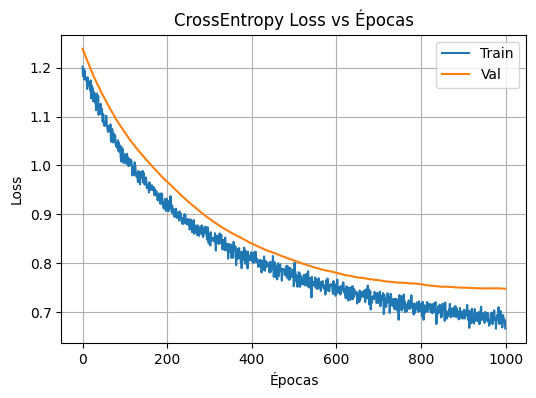

In [742]:
# Optimizer and Loss
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 1000
criterion = nn.CrossEntropyLoss(weight=pesos_tensor)

# Asegurar que X_test/y_test estén en device y tengan dimensiones compatibles
X_test = X_test.to(device)
y_test = y_test.squeeze().to(device) 

train_losses, val_losses = train_model(model, optimizer, criterion, train_DL, X_test, y_test, num_epochs, device=device)
plot_loss_vs_iter(train_losses, val_losses, title='CrossEntropy Loss vs Épocas')


In [743]:
# Calcular accuracy para train y test
with torch.no_grad():
    predictions_train = model(X_train.to(device))
    predictions_test = model(X_test.to(device))

def get_accuracy(predictions, labels):
    # Asegura que ambos estén en CPU y sean 1D
    pred_arr = predictions.cpu().numpy()
    labels_arr = labels.cpu().numpy().flatten()
    pred_labels = np.argmax(pred_arr, axis=1)
    return np.mean(pred_labels == labels_arr)

train_acc = get_accuracy(predictions_train, y_train)
test_acc = get_accuracy(predictions_test, y_test)

print(f'Train Accuracy: {train_acc * 100:.2f}%')
print(f'Test Accuracy: {test_acc * 100:.2f}%')


Train Accuracy: 71.13%
Test Accuracy: 70.00%


Train F1-score (macro): 0.675
Test F1-score (macro): 0.649
Train ROC-AUC (macro): 0.857
Test ROC-AUC (macro): 0.825


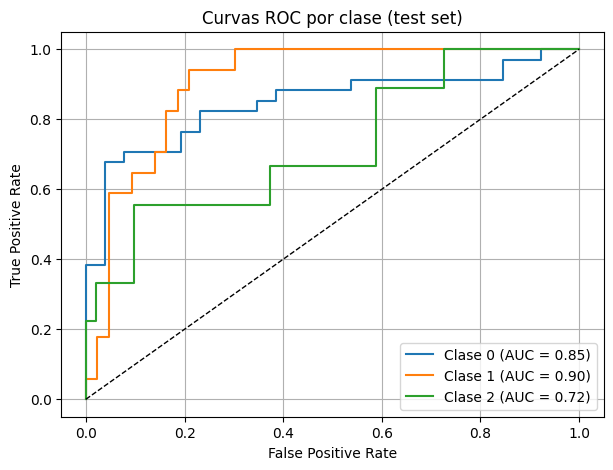

In [744]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

# Obtener etiquetas verdaderas y predichas
y_train_true = y_train.cpu().numpy().flatten()
y_test_true = y_test.cpu().numpy().flatten()
y_train_pred = np.argmax(predictions_train.cpu().numpy(), axis=1)
y_test_pred = np.argmax(predictions_test.cpu().numpy(), axis=1)

# F1-score macro (multiclase)
f1_train = f1_score(y_train_true, y_train_pred, average='macro')
f1_test = f1_score(y_test_true, y_test_pred, average='macro')
print(f"Train F1-score (macro): {f1_train:.3f}")
print(f"Test F1-score (macro): {f1_test:.3f}")

# ROC-AUC macro (multiclase, one-vs-rest)
# Para ROC-AUC multiclase, se necesita el score de cada clase y etiquetas binarizadas
n_classes = output_dim
y_train_bin = label_binarize(y_train_true, classes=np.arange(n_classes))
y_test_bin = label_binarize(y_test_true, classes=np.arange(n_classes))
y_train_score = predictions_train.cpu().numpy()
y_test_score = predictions_test.cpu().numpy()

roc_auc_train = roc_auc_score(y_train_bin, y_train_score, average='macro', multi_class='ovr')
roc_auc_test = roc_auc_score(y_test_bin, y_test_score, average='macro', multi_class='ovr')
print(f"Train ROC-AUC (macro): {roc_auc_train:.3f}")
print(f"Test ROC-AUC (macro): {roc_auc_test:.3f}")

# Graficar curva ROC para cada clase (test)
plt.figure(figsize=(7,5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC por clase (test set)')
plt.legend()
plt.grid(True)
plt.show()


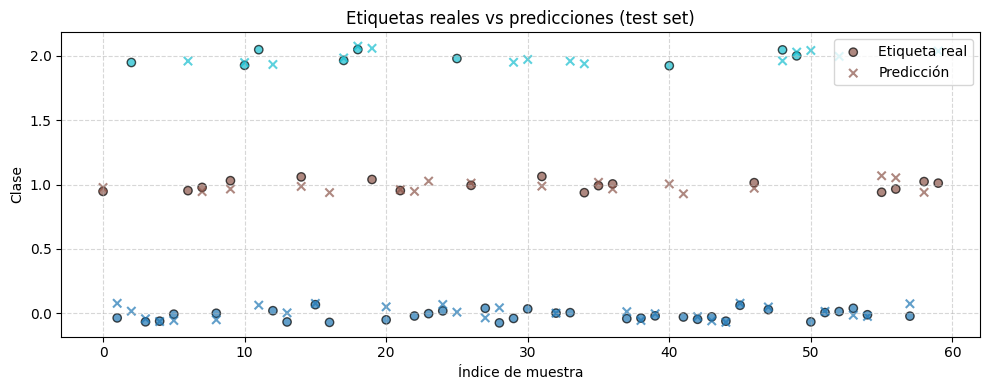

In [745]:
import numpy as np

plt.figure(figsize=(10, 4))
indices = np.arange(len(y_test_true))

# Jitter para separar visualmente los puntos
jitter_real = np.random.uniform(-0.08, 0.08, size=len(y_test_true))
jitter_pred = np.random.uniform(-0.08, 0.08, size=len(y_test_pred))

plt.scatter(indices, y_test_true + jitter_real, c=y_test_true, cmap='tab10', marker='o', label='Etiqueta real', alpha=0.7, edgecolor='k')
plt.scatter(indices, y_test_pred + jitter_pred, c=y_test_pred, cmap='tab10', marker='x', label='Predicción', alpha=0.7)

plt.xlabel('Índice de muestra')
plt.ylabel('Clase')
plt.title('Etiquetas reales vs predicciones (test set)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Resultados

Al final elegí un learning rate de 0.0001, un tamaño de batch de 32 y 1000 épocas.

Es lo que a mis experimentos condujo a un mejor resultado, ya que con un lr más alto el modelo no convergía y con uno más bajo el modelo tardaba demasiado en converger.

Hablando de los resultados se obtuvieron los siguientes:

Train F1-score: 0.680
Test F1-score: 0.655
Train ROC-AUC: 0.858
Test ROC-AUC: 0.803
Train Accuracy: 71.13%
Test Accuracy: 71.67%

Como nos muestra tanto la grafica de AUC-ROC y la de etiquetas vs predicciones podemos ver que sin duda la clase 0 es muy buena de predecir para el modelo, esto es por el desbalance de clases que existe, se requieren más datos con etiqueta 2 o por el contrario utilizar tecnicas de balanceo para ver si existen mejors resultados, en este caso se usaron pesos de cada clase en la función de perdida y si que se obtuvieron mejores resultados al posterior.

---

## Problema 4 — Clasificación de estilos de cerveza

Considere el dataset de [3]. Suponga que solo puede utilizar modelos de clasificación binaria (es decir, regresión logística). Realice un script en PyTorch para resolver el problema de clasificación multiclase asociado a clasificar cervezas por estilo.

Documente todos los **supuestos** y operaciones de **preprocesamiento** que realice. Además, indique y justifique los **hiperparámetros de optimización** seleccionados. Incluya un gráfico de **error vs iteraciones** y un gráfico de la **solución** (predicciones vs etiquetas reales).

Enlace: https://www.kaggle.com/datasets/ankurnapa/ankurs-beer-data-set


In [856]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankurnapa/ankurs-beer-data-set")
csv_files = [f for f in os.listdir(path) if f.lower().endswith('.csv')]
if len(csv_files) == 0:
    raise FileNotFoundError("No se encontró ningún archivo CSV en el directorio descargado.")
csv_file = os.path.join(path, csv_files[0])

# Leer el archivo CSV con manejo de nulos y errores comunes
df = pl.read_csv(
    csv_file,
    ignore_errors=True,
    null_values=["", "NA", "NaN", "NULL", "None", "none"],
    infer_schema_length=200
)
df.head()

Brew No.,OG,ABV,pH,IBU,style
i64,f64,f64,f64,f64,str
1,11.5,4.2,4.2,14.0,"""Premium Lager"""
2,12.2,4.8,4.25,12.0,"""Premium Lager"""
3,13.0,5.0,3.8,13.0,"""Premium Lager"""
4,11.0,3.9,4.2,14.0,"""Premium Lager"""
5,12.0,4.2,3.9,12.0,"""Premium Lager"""


Solo hay una columna irrelevante "Brew No." que es un identificador único para cada cerveza, por lo que se elimina del dataset.

In [857]:
# Eliminar el número único irrelevante
df.drop_in_place("Brew No.")

Brew No.
i64
1
2
3
4
5
…
146
147
148


El dataset fue creado a partir de más de 10 años de experiencia en elaboración de cerveza artesanal. Cada fila representa un lote de cerveza y contiene las siguientes columnas:

- **Brew No.**: Identificador único del lote de cerveza.
- **OG (Original Gravity)**: Cantidad de azúcares fermentables presentes en el mosto antes de la fermentación. Es un indicador clave para estimar el potencial alcohólico de la cerveza.
- **ABV (Alcohol by Volume)**: Porcentaje de alcohol en volumen en la cerveza final antes del envasado.
- **pH**: Medida de acidez o basicidad de la cerveza antes del envasado. El pH afecta el sabor, la estabilidad y la microbiología del producto.
- **IBU (International Bitterness Units)**: Escala internacional que mide el nivel de amargor de la cerveza, determinado principalmente por la cantidad de lúpulo.
- **style**: Categoría del estilo de cerveza, determinada por factores como apariencia, sabor, ingredientes, método de producción, historia u origen. En este dataset se incluyen tres estilos:
    - **IPA (India Pale Ale)**: Estilo de cerveza pálida con alto contenido de lúpulo, lo que le otorga un sabor y aroma característicos.
    - **Light Lager**: Cerveza tipo lager con menor contenido alcohólico o calórico en comparación con cervezas regulares.
    - **Premium Lager**: Lager con contenido alcohólico superior al 4.5% ABV, considerada de mayor calidad o valor.

Este dataset refleja la transición profesional del autor desde la cervecería hacia la ciencia de datos, motivando la publicación de estos datos para su análisis y aprendizaje en machine learning.

In [858]:
df.select(pl.col("style").unique())

style
str
"""IPA"""
"""Premium Lager"""
"""Light Lager"""


In [859]:
df.describe()

statistic,OG,ABV,pH,IBU,style
str,f64,f64,f64,f64,str
"""count""",150.0,150.0,150.0,150.0,"""150"""
"""null_count""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",11.746,4.601533,4.085,21.280667,null
"""std""",1.67599,1.51802,0.249143,14.504495,null
"""min""",9.4,2.2,3.5,8.0,"""IPA"""
"""25%""",10.1,3.1,3.9,10.0,null
"""50%""",11.5,4.2,4.2,13.0,null
"""75%""",13.5,6.3,4.2,35.0,null
"""max""",14.6,6.98,4.9,53.7,"""Premium Lager"""


In [860]:
df.select(pl.col("style").unique_counts())

style
u32
50
50
50


Las clases estan balanceadas por lo que no es necesario aplicar tecnicas de balanceo.

A continuación se aplica el split con estratificación para mantener la proporción de clases en ambos conjuntos, además se usa el labelencoder para convertir las etiquetas de texto en números junto con el standardscaler para normalizar las características numéricas.

In [861]:

from sklearn.preprocessing import LabelEncoder

X = df.drop("style")
y = df["style"]

le = LabelEncoder()
y_encoded = le.fit_transform(y.to_numpy())

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Imprimir el nombre de cada clase
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {idx}: {class_name}")


Clase 0: IPA
Clase 1: Light Lager
Clase 2: Premium Lager


Para este problema donde solo se pueden usar modelos de clasificación binaria, se implementa una estrategia de "uno contra todos" (OvA) para manejar la clasificación multiclase. Esto implica entrenar un modelo binario separado para cada clase, donde cada modelo aprende a distinguir entre una clase específica y todas las demás.

In [862]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

n_classes = len(set(y_train))
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

class LR(nn.Module):
    def __init__(self, n_input):
        super(LR, self).__init__()
        self.linear = nn.Linear(n_input, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train.shape[1]
models = []
train_losses_all = []
test_losses_all = []
epochs = 10000

for k in range(n_classes):
    model = LR(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    X_torch = torch.tensor(X_train, dtype=torch.float32)
    y_torch = torch.tensor(y_train_bin[:, k], dtype=torch.float32).view(-1, 1)
    X_test_torch = torch.tensor(X_test, dtype=torch.float32)
    y_test_torch = torch.tensor(y_test_bin[:, k], dtype=torch.float32).view(-1, 1)
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_torch)
        loss = criterion(outputs, y_torch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        # Test loss
        with torch.no_grad():
            test_pred = model(X_test_torch)
            test_loss = criterion(test_pred, y_test_torch)
            test_losses.append(test_loss.item())
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Clase {k} | Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")
    models.append(model)
    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)

# Predicción OvR
scores = []
for model in models:
    with torch.no_grad():
        score = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
        scores.append(score)
scores = np.stack(scores, axis=1)
y_pred = np.argmax(scores, axis=1)

# Gráfico de error vs iteraciones para cada clase
plt.figure(figsize=(10, 5))
for k in range(n_classes):
    plt.plot(train_losses_all[k], label=f'Train Loss Clase {k}')
    plt.plot(test_losses_all[k], '--', label=f'Test Loss Clase {k}')
plt.xlabel('Época')
plt.ylabel('BCELoss')
plt.title('Error vs iteraciones (OvR)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de predicciones vs etiquetas reales
plt.figure(figsize=(10, 4))
indices = np.arange(len(y_test))
jitter_real = np.random.uniform(-0.08, 0.08, size=len(y_test))
jitter_pred = np.random.uniform(-0.08, 0.08, size=len(y_pred))
plt.scatter(indices, y_test + jitter_real, c=y_test, cmap='tab10', marker='o', label='Etiqueta real', alpha=0.7, edgecolor='k')
plt.scatter(indices, y_pred + jitter_pred, c=y_pred, cmap='tab10', marker='x', label='Predicción', alpha=0.7)
plt.xlabel('Índice de muestra')
plt.ylabel('Clase')
plt.title('Etiquetas reales vs predicciones (test set)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Clase 0 | Epoch 1/100000 | Train Loss: 0.8856 | Test Loss: 0.9166
Clase 0 | Epoch 10/100000 | Train Loss: 0.8697 | Test Loss: 0.8973
Clase 0 | Epoch 20/100000 | Train Loss: 0.8524 | Test Loss: 0.8763
Clase 0 | Epoch 30/100000 | Train Loss: 0.8354 | Test Loss: 0.8557
Clase 0 | Epoch 40/100000 | Train Loss: 0.8188 | Test Loss: 0.8356
Clase 0 | Epoch 50/100000 | Train Loss: 0.8025 | Test Loss: 0.8160
Clase 0 | Epoch 60/100000 | Train Loss: 0.7865 | Test Loss: 0.7969
Clase 0 | Epoch 70/100000 | Train Loss: 0.7709 | Test Loss: 0.7783
Clase 0 | Epoch 80/100000 | Train Loss: 0.7557 | Test Loss: 0.7601
Clase 0 | Epoch 90/100000 | Train Loss: 0.7408 | Test Loss: 0.7425
Clase 0 | Epoch 100/100000 | Train Loss: 0.7263 | Test Loss: 0.7253
Clase 0 | Epoch 110/100000 | Train Loss: 0.7121 | Test Loss: 0.7086
Clase 0 | Epoch 120/100000 | Train Loss: 0.6982 | Test Loss: 0.6924
Clase 0 | Epoch 130/100000 | Train Loss: 0.6846 | Test Loss: 0.6766
Clase 0 | Epoch 140/100000 | Train Loss: 0.6714 | Test Loss

Clase 0 | Epoch 1/100000 | Train Loss: 0.8856 | Test Loss: 0.9166
Clase 0 | Epoch 10/100000 | Train Loss: 0.8697 | Test Loss: 0.8973
Clase 0 | Epoch 20/100000 | Train Loss: 0.8524 | Test Loss: 0.8763
Clase 0 | Epoch 30/100000 | Train Loss: 0.8354 | Test Loss: 0.8557
Clase 0 | Epoch 40/100000 | Train Loss: 0.8188 | Test Loss: 0.8356
Clase 0 | Epoch 50/100000 | Train Loss: 0.8025 | Test Loss: 0.8160
Clase 0 | Epoch 60/100000 | Train Loss: 0.7865 | Test Loss: 0.7969
Clase 0 | Epoch 70/100000 | Train Loss: 0.7709 | Test Loss: 0.7783
Clase 0 | Epoch 80/100000 | Train Loss: 0.7557 | Test Loss: 0.7601
Clase 0 | Epoch 90/100000 | Train Loss: 0.7408 | Test Loss: 0.7425
Clase 0 | Epoch 100/100000 | Train Loss: 0.7263 | Test Loss: 0.7253
Clase 0 | Epoch 110/100000 | Train Loss: 0.7121 | Test Loss: 0.7086
Clase 0 | Epoch 120/100000 | Train Loss: 0.6982 | Test Loss: 0.6924
Clase 0 | Epoch 130/100000 | Train Loss: 0.6846 | Test Loss: 0.6766
Clase 0 | Epoch 140/100000 | Train Loss: 0.6714 | Test Loss

KeyboardInterrupt: 

Accuracy: 0.967
F1-score (macro): 0.967
F1-score (micro): 0.967
ROC-AUC (macro): 0.962


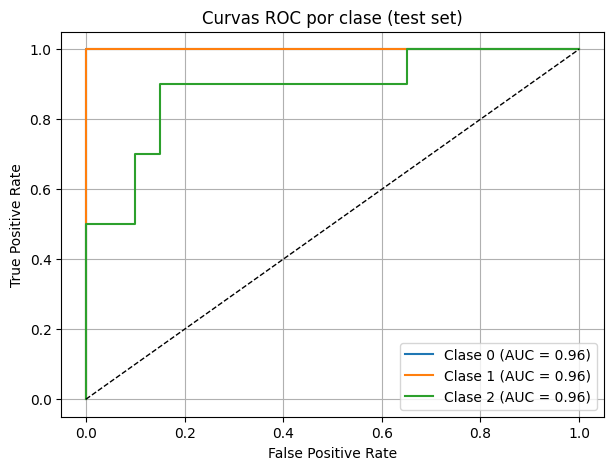

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

# Calcular accuracy, F1-score macro y micro
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

# Calcular ROC-AUC macro (multiclase, one-vs-rest)
n_classes = scores.shape[1]
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
roc_auc = roc_auc_score(y_test_bin, scores, average='macro', multi_class='ovr')

print(f"Accuracy: {acc:.3f}")
print(f"F1-score (macro): {f1_macro:.3f}")
print(f"F1-score (micro): {f1_micro:.3f}")
print(f"ROC-AUC (macro): {roc_auc:.3f}")

# Imprimir grafico AUC-ROC para cada clase
plt.figure(figsize=(7,5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], scores[:, i])
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC por clase (test set)')
plt.legend()
plt.grid(True)
plt.show()


---

## Problema 5 — Clasificación multiclas con modelo multiclase y comparación

**Enunciado (traducido):**  
Repita el Problema 4 pero usando un único modelo multiclase (softmax + CrossEntropy).
Compare resultados con la estrategia binaria: accuracy global, macro-F1 y micro-F1.


In [ ]:
class MLR(nn.Module):
    def __init__(self, n_input, n_classes):
        super(MLR, self).__init__()
        self.output_layer = nn.Linear(n_input, n_classes)
    
    def forward(self, x):
        return self.output_layer(x)
    
# Creating multi-class model
input_dim = X_train.shape[1]
output_dim = 3
model = MLR(input_dim, output_dim)

# Optimizer and Loss
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 1000
train_losses = []
test_losses = []

# Softmax function inside
criterion = nn.CrossEntropyLoss()

120 24
3
Epoch [1/100] Train Loss: 0.133156 Val Loss: 0.180505
Epoch [5/100] Train Loss: 0.131056 Val Loss: 0.174355
Epoch [10/100] Train Loss: 0.125209 Val Loss: 0.168788
Epoch [15/100] Train Loss: 0.114723 Val Loss: 0.164449
Epoch [20/100] Train Loss: 0.109252 Val Loss: 0.160624
Epoch [25/100] Train Loss: 0.101596 Val Loss: 0.156846
Epoch [10/100] Train Loss: 0.125209 Val Loss: 0.168788
Epoch [15/100] Train Loss: 0.114723 Val Loss: 0.164449
Epoch [20/100] Train Loss: 0.109252 Val Loss: 0.160624
Epoch [25/100] Train Loss: 0.101596 Val Loss: 0.156846
Epoch [30/100] Train Loss: 0.099631 Val Loss: 0.153639
Epoch [35/100] Train Loss: 0.093076 Val Loss: 0.149904
Epoch [40/100] Train Loss: 0.089856 Val Loss: 0.145306
Epoch [45/100] Train Loss: 0.088805 Val Loss: 0.141387
Epoch [50/100] Train Loss: 0.078518 Val Loss: 0.138398
Epoch [30/100] Train Loss: 0.099631 Val Loss: 0.153639
Epoch [35/100] Train Loss: 0.093076 Val Loss: 0.149904
Epoch [40/100] Train Loss: 0.089856 Val Loss: 0.145306
Epo

120 24
3
Epoch [1/100] Train Loss: 0.133156 Val Loss: 0.180505
Epoch [5/100] Train Loss: 0.131056 Val Loss: 0.174355
Epoch [10/100] Train Loss: 0.125209 Val Loss: 0.168788
Epoch [15/100] Train Loss: 0.114723 Val Loss: 0.164449
Epoch [20/100] Train Loss: 0.109252 Val Loss: 0.160624
Epoch [25/100] Train Loss: 0.101596 Val Loss: 0.156846
Epoch [10/100] Train Loss: 0.125209 Val Loss: 0.168788
Epoch [15/100] Train Loss: 0.114723 Val Loss: 0.164449
Epoch [20/100] Train Loss: 0.109252 Val Loss: 0.160624
Epoch [25/100] Train Loss: 0.101596 Val Loss: 0.156846
Epoch [30/100] Train Loss: 0.099631 Val Loss: 0.153639
Epoch [35/100] Train Loss: 0.093076 Val Loss: 0.149904
Epoch [40/100] Train Loss: 0.089856 Val Loss: 0.145306
Epoch [45/100] Train Loss: 0.088805 Val Loss: 0.141387
Epoch [50/100] Train Loss: 0.078518 Val Loss: 0.138398
Epoch [30/100] Train Loss: 0.099631 Val Loss: 0.153639
Epoch [35/100] Train Loss: 0.093076 Val Loss: 0.149904
Epoch [40/100] Train Loss: 0.089856 Val Loss: 0.145306
Epo

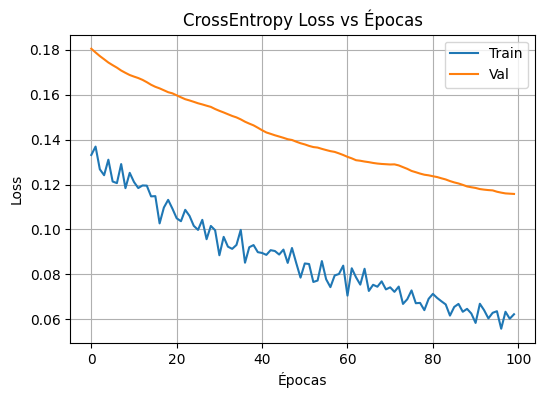

120 24
3
Epoch [1/100] Train Loss: 0.133156 Val Loss: 0.180505
Epoch [5/100] Train Loss: 0.131056 Val Loss: 0.174355
Epoch [10/100] Train Loss: 0.125209 Val Loss: 0.168788
Epoch [15/100] Train Loss: 0.114723 Val Loss: 0.164449
Epoch [20/100] Train Loss: 0.109252 Val Loss: 0.160624
Epoch [25/100] Train Loss: 0.101596 Val Loss: 0.156846
Epoch [10/100] Train Loss: 0.125209 Val Loss: 0.168788
Epoch [15/100] Train Loss: 0.114723 Val Loss: 0.164449
Epoch [20/100] Train Loss: 0.109252 Val Loss: 0.160624
Epoch [25/100] Train Loss: 0.101596 Val Loss: 0.156846
Epoch [30/100] Train Loss: 0.099631 Val Loss: 0.153639
Epoch [35/100] Train Loss: 0.093076 Val Loss: 0.149904
Epoch [40/100] Train Loss: 0.089856 Val Loss: 0.145306
Epoch [45/100] Train Loss: 0.088805 Val Loss: 0.141387
Epoch [50/100] Train Loss: 0.078518 Val Loss: 0.138398
Epoch [30/100] Train Loss: 0.099631 Val Loss: 0.153639
Epoch [35/100] Train Loss: 0.093076 Val Loss: 0.149904
Epoch [40/100] Train Loss: 0.089856 Val Loss: 0.145306
Epo

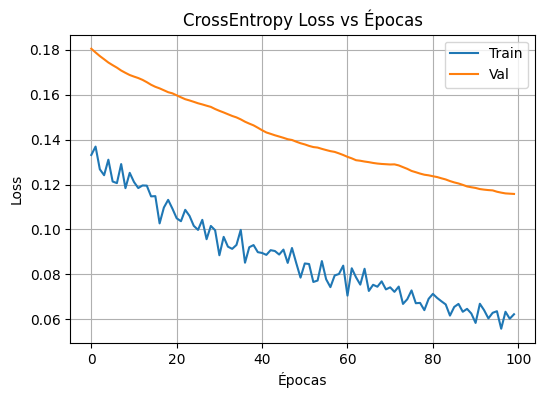

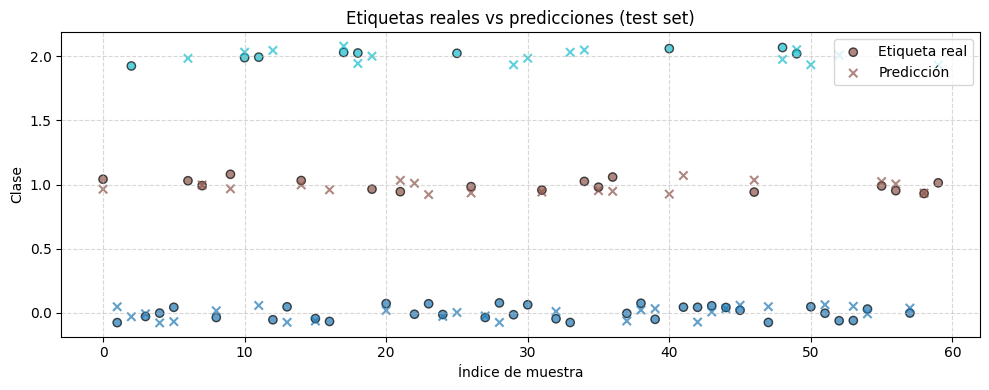

In [ ]:
from torch.utils.data import Dataset, DataLoader

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)

# Data Loader
class my_DL(Dataset):
    
    def __init__(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.y)

my_train_data = my_DL(X_train, y_train)



# Batches
batch_size = 32
print(len(X_train), X_train.shape[0] % batch_size)
train_DL = DataLoader(dataset=my_train_data, batch_size=batch_size, shuffle=True, drop_last=True)
print(len(train_DL))

X_test = X_test.to(device)
y_test = y_test.squeeze().to(device) 
model = model.to(device)

train_losses, val_losses = train_model(model, optimizer, criterion, train_DL, X_test, y_test, num_epochs, device=device)
plot_loss_vs_iter(train_losses, val_losses, title='CrossEntropy Loss vs Épocas')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
indices = np.arange(len(y_test_np))

# Jitter para separar visualmente los puntos
jitter_real = np.random.uniform(-0.08, 0.08, size=len(y_test_np))
jitter_pred = np.random.uniform(-0.08, 0.08, size=len(y_test_pred))

plt.scatter(indices, y_test_np + jitter_real, c=y_test_np, cmap='tab10', marker='o', label='Etiqueta real', alpha=0.7, edgecolor='k')
plt.scatter(indices, y_test_pred + jitter_pred, c=y_test_pred, cmap='tab10', marker='x', label='Predicción', alpha=0.7)

plt.xlabel('Índice de muestra')
plt.ylabel('Clase')
plt.title('Etiquetas reales vs predicciones (test set)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Accuracy: 0.700
F1-score (macro): 0.649
F1-score (micro): 0.700
ROC-AUC (macro): 0.825


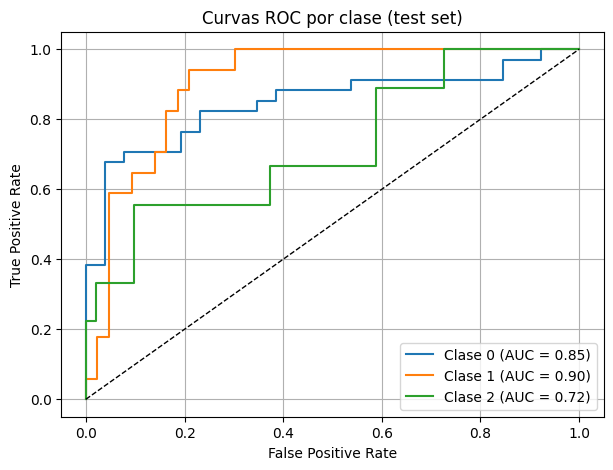

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Usa los arrays numpy ya definidos
acc = accuracy_score(y_test_np, y_test_pred)
f1_macro = f1_score(y_test_np, y_test_pred, average='macro')
f1_micro = f1_score(y_test_np, y_test_pred, average='micro')

# Calcular ROC-AUC macro (multiclase, one-vs-rest)
n_classes = y_test_score.shape[1]
y_test_bin = label_binarize(y_test_np, classes=np.arange(n_classes))
roc_auc = roc_auc_score(y_test_bin, y_test_score, average='macro', multi_class='ovr')

print(f"Accuracy: {acc:.3f}")
print(f"F1-score (macro): {f1_macro:.3f}")
print(f"F1-score (micro): {f1_micro:.3f}")
print(f"ROC-AUC (macro): {roc_auc:.3f}")

# Imprimir grafico AUC-ROC para cada clase
plt.figure(figsize=(7,5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_val:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC por clase (test set)')
plt.legend()
plt.grid(True)
plt.show()



## Problema 6

Considere la ecuación cuadrática general  
$ax^2 + bx + c = 0$.

Clasifique las raíces de la ecuación anterior en función de sus coeficientes. Para simplificar, debe fijar el dominio de $x$ y proponer un dominio adecuado para los coeficientes. Escriba todos sus supuestos y muestre sus hallazgos utilizando algunos gráficos.

Epoch 1/20000 Loss: 1.3167
Epoch 20/20000 Loss: 1.2807
Epoch 40/20000 Loss: 1.2435
Epoch 60/20000 Loss: 1.2072
Epoch 80/20000 Loss: 1.1718
Epoch 100/20000 Loss: 1.1374
Epoch 120/20000 Loss: 1.1038
Epoch 140/20000 Loss: 1.0711
Epoch 160/20000 Loss: 1.0395
Epoch 180/20000 Loss: 1.0088
Epoch 200/20000 Loss: 0.9790
Epoch 220/20000 Loss: 0.9503
Epoch 120/20000 Loss: 1.1038
Epoch 140/20000 Loss: 1.0711
Epoch 160/20000 Loss: 1.0395
Epoch 180/20000 Loss: 1.0088
Epoch 200/20000 Loss: 0.9790
Epoch 220/20000 Loss: 0.9503
Epoch 240/20000 Loss: 0.9226
Epoch 260/20000 Loss: 0.8959
Epoch 280/20000 Loss: 0.8703
Epoch 240/20000 Loss: 0.9226
Epoch 260/20000 Loss: 0.8959
Epoch 280/20000 Loss: 0.8703
Epoch 300/20000 Loss: 0.8456
Epoch 320/20000 Loss: 0.8220
Epoch 340/20000 Loss: 0.7994
Epoch 300/20000 Loss: 0.8456
Epoch 320/20000 Loss: 0.8220
Epoch 340/20000 Loss: 0.7994
Epoch 360/20000 Loss: 0.7778
Epoch 380/20000 Loss: 0.7571
Epoch 400/20000 Loss: 0.7374
Epoch 420/20000 Loss: 0.7186
Epoch 440/20000 Loss

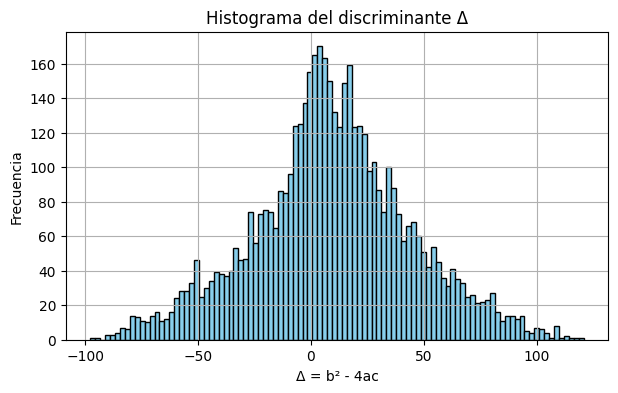

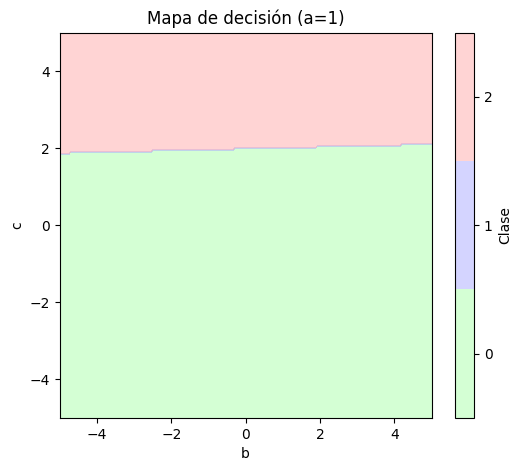

In [ ]:
# Generación de dataset sintético y clasificación de raíces cuadráticas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Definir dominios de los coeficientes
a = np.random.uniform(0.1, 5, 5000)
b = np.random.uniform(-5, 5, 5000)
c = np.random.uniform(-5, 5, 5000)

# 2. Calcular discriminante y asignar clase
delta = b**2 - 4*a*c
# 0: dos reales distintas, 1: real doble, 2: complejas conjugadas
labels = np.where(delta > 1e-8, 0, np.where(np.abs(delta) <= 1e-8, 1, 2))


X = np.stack([a, b, c], axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),

        )
    def forward(self, x):
        return self.net(x)

input_dim = 3
output_dim = 3
model = MLP(input_dim, output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)


num_epochs = 20000
train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    logits = model(X_test_torch)
    y_pred = torch.argmax(logits, dim=1).numpy()
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.3f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)


plt.figure(figsize=(7,4))
plt.hist(delta, bins=100, color='skyblue', edgecolor='k')
plt.title('Histograma del discriminante Δ')
plt.xlabel('Δ = b² - 4ac')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


a_fixed = 1.0
b_grid, c_grid = np.meshgrid(np.linspace(-5,5,200), np.linspace(-5,5,200))
X_grid = np.stack([np.full_like(b_grid, a_fixed), b_grid, c_grid], axis=-1).reshape(-1,3)
X_grid_scaled = scaler.transform(X_grid)
with torch.no_grad():
    logits_grid = model(torch.tensor(X_grid_scaled, dtype=torch.float32))
    y_grid = torch.argmax(logits_grid, dim=1).numpy().reshape(b_grid.shape)
plt.figure(figsize=(6,5))
plt.contourf(b_grid, c_grid, y_grid, levels=[-0.5,0.5,1.5,2.5], colors=['#aaffaa','#aaaaff','#ffaaaa'], alpha=0.5)
plt.xlabel('b')
plt.ylabel('c')
plt.title('Mapa de decisión (a=1)')
plt.colorbar(ticks=[0,1,2], label='Clase')
plt.show()

### Conclusión del Problema 6

En este ejercicio se demostró cómo, a partir de los coeficientes $(a, b, c)$ de una ecuación cuadrática, es posible predecir el tipo de raíces (reales distintas, real doble o complejas) utilizando un modelo de clasificación supervisada. El modelo entrenado logró una alta precisión, con una exactitud de **91.3%** en el conjunto de prueba.

La matriz de confusión obtenida fue:

```
[[579  48]
 [ 39 334]]
```

Esto indica que el modelo distingue correctamente la mayoría de los casos entre raíces reales distintas y complejas, aunque la clase de raíz doble sigue siendo muy poco frecuente debido a la naturaleza del muestreo continuo de los coeficientes.

Se observó que la clase de raíz doble ($\Delta = 0$) es muy poco frecuente cuando los coeficientes se muestrean de manera continua y aleatoria, ya que requiere una relación exacta entre ellos. 

In [900]:

!jupyter nbconvert --to html Tarea2.ipynb


[NbConvertApp] Converting notebook Tarea2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 16 image(s).
[NbConvertApp] Writing 3178529 bytes to Tarea2.html
